In [1]:
from utils import set_env
import time
set_env()
import torch
from datasets import load_dataset
from peft import LoraConfig, get_peft_model
from PIL import Image
from transformers import IdeficsForVisionText2Text, AutoProcessor, Trainer, TrainingArguments, BitsAndBytesConfig

/work/cvp352/loi_work/2025/Pro-Cap/.venv/lib64/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
checkpoint = "HuggingFaceM4/idefics-9b"
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,
    llm_int8_skip_modules=["lm_head", "embed_tokens"]
)

In [4]:
processor = AutoProcessor.from_pretrained(checkpoint)
model = IdeficsForVisionText2Text.from_pretrained(checkpoint, quantization_config=bnb_config, device_map="auto")

Instantiating IdeficsAttention without passing a `layer_idx` is not recommended and will lead to errors during the forward call if caching is used. Please make sure to provide a `layer_idx` when creating this class.
Loading checkpoint shards: 100%|██████████| 19/19 [01:35<00:00,  5.01s/it]


In [5]:
sum([x.numel() for x in model.parameters()])/1e9

4.5969636

In [6]:
# Inference
def do_inference(model, processor, prompts, max_new_tokens=50):
    tokenizer = processor.tokenizer
    bad_words = ["<image>", "<fake_token_around_image>"]
    if len(bad_words) > 0:
        bad_words_ids = tokenizer(bad_words, add_special_tokens=False).input_ids
    eos_token = "</s>"
    eos_token_id = tokenizer.convert_tokens_to_ids(eos_token)

    inputs = processor(prompts, return_tensors="pt").to(device)
    generated_ids = model.generate(
        **inputs,
        eos_token_id=[eos_token_id],
        bad_words_ids=bad_words_ids,
        max_new_tokens=max_new_tokens,
        early_stopping=True
    )
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
    print(generated_text)

In [7]:
import torchvision.transforms as transforms

In [8]:
url = "https://hips.hearstapps.com/hmg-prod/images/cute-photos-of-cats-in-grass-1593184777.jpg"
prompts = [
    url,
    "Question: What's on the picture? Answer:",
]

In [9]:
##preprocessing
def convert_to_rgb(image):
  if image.mode == "RGB":
    return image

  image_rgba = image.convert("RGBA")
  background = Image.new("RGBA", image_rgba.size, (255,255,255))
  alpha_composite = Image.alpha_composite(background, image_rgba)
  alpha_composite = alpha_composite.convert("RGB")
  return alpha_composite

def ds_transforms(example_batch):
  image_size = processor.image_processor.image_size
  image_mean = processor.image_processor.image_mean
  image_std = processor.image_processor.image_std

  image_transform = transforms.Compose([
      convert_to_rgb,
      transforms.RandomResizedCrop((image_size, image_size), scale=(0.9, 1.0), interpolation=transforms.InterpolationMode.BICUBIC),
      transforms.ToTensor(),
      transforms.Normalize(mean=image_mean, std=image_std)
  ])

  prompts = []
  for i in range(len(example_batch['caption'])):
    caption = example_batch['caption'][i].split(".")[0]
    prompts.append(
        [
            example_batch['image_url'][i],
            f"Question: What's on the picture? Answer: This is {example_batch['name']}. {caption}</s>",
        ],
    )
  inputs = processor(prompts, transform=image_transform, return_tensors="pt").to(device)
  inputs["labels"] = inputs["input_ids"]
  return inputs

In [10]:
#Load and prepare the data
ds = load_dataset("TheFusion21/PokemonCards")
ds = ds["train"].train_test_split(test_size=0.002)
train_ds = ds["train"]
eval_ds = ds["test"]
train_ds.set_transform(ds_transforms)
eval_ds.set_transform(ds_transforms)

In [11]:
train_ds[0]['labels']

You may have used the wrong order for inputs. `images` should be passed before `text`. The `images` and `text` inputs will be swapped. This behavior will be deprecated in transformers v4.47.


tensor([    1, 32000, 32001, 32000,   894, 29901,  1724, 29915, 29879,   373,
          278,  7623, 29973,   673, 29901,   910,   338,  6024, 10095,   351,
         2124,   478, 13359,   319, 19219, 29892,   478, 29892, 16866,   333,
          624, 20995, 21747,  9857,  9160,   310,  1134, 24992,   411,   278,
         3611,  4737,   351,  2124,   478,   322, 29871, 29906, 29906, 29900,
          379, 29925,   310,   364,   279,   537,   390,   598, 18514,   336,
          515,   278,   731,   678,  8873,   830,   647,     2],
       device='cuda:0')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7922626..2.145897].


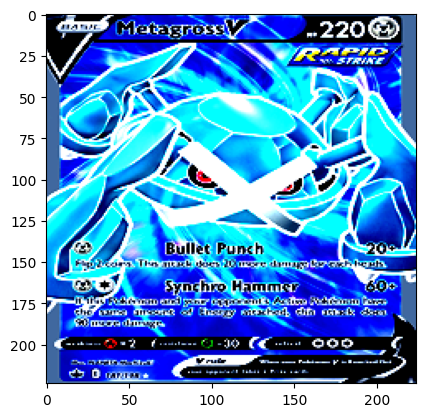

In [12]:
import matplotlib.pyplot as plt
plt.imshow( train_ds[0]['pixel_values'].cpu().squeeze(0).permute(1,2,0))

In [13]:
model_name = checkpoint.split("/")[1]
config = LoraConfig(
    r = 16,
    lora_alpha = 32,
    target_modules = ["q_proj", "k_proj", "v_proj"],
    lora_dropout = 0.05,
    bias="none"
)

In [14]:
model = get_peft_model(model, config)
model.print_trainable_parameters()

trainable params: 19,750,912 || all params: 8,949,430,544 || trainable%: 0.2207


In [15]:
training_args = TrainingArguments(
    output_dir = f"{model_name}-PokemonCards",
    learning_rate = 2e-4,
    fp16 = True,
    per_device_train_batch_size = 2,
    per_device_eval_batch_size = 2,
    gradient_accumulation_steps = 8,
    dataloader_pin_memory = False,
    save_total_limit = 3,
    evaluation_strategy ="steps",
    save_strategy = "steps",
    eval_steps = 10,
    save_steps = 25,
    max_steps = 25,
    logging_steps = 5,
    remove_unused_columns = False,
    push_to_hub=False,
    label_names = ["labels"],
    load_best_model_at_end = False,
    report_to = "none",
    optim = "paged_adamw_8bit",
)

/work/cvp352/loi_work/2025/Pro-Cap/.venv/lib64/python3.11/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [16]:
type(training_args)

transformers.training_args.TrainingArguments

In [17]:
trainer = Trainer(
    model = model,
    args = training_args,
    train_dataset = train_ds,
    eval_dataset = eval_ds
)

Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


In [18]:
trainer.train()

Step,Training Loss,Validation Loss


HTTPError: 404 Client Error: Not Found for url: https://images.pokemontcg.io/mcd14/7_hires.png

In [53]:
url = "https://images.pokemontcg.io/pop6/2_hires.png"

In [54]:
prompts = [
    url,
    "Question: What's on the picture? Answer:",
]

In [55]:
do_inference(model, processor, prompts, max_new_tokens=100)

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:433: UserWarning: `num_beams` is set to 1. However, `early_stopping` is set to `True` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `early_stopping`.
  warnings.warn(


Question: What's on the picture? Answer: This is ['Lucario', 'Gardevoir']. A Basic Pokemon Card of type Darkness with the title Lucario and 90 HP of rarity Rare Holo from the set Black Star Promos and the flavor text: It is said that Lucario is a Pokemon that can only be found in the deepest parts of the forest


In [57]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

## Push to hub

In [59]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Token: 
Add token as git credential? (Y/n) n
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [60]:
model.push_to_hub(f"{model_name}-PokemonCards", private=False)

adapter_model.safetensors:   0%|          | 0.00/79.1M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/skuma307/idefics-9b-PokemonCards/commit/258ff93d25bd52369255a3b339d2a492b3eff3c7', commit_message='Upload model', commit_description='', oid='258ff93d25bd52369255a3b339d2a492b3eff3c7', pr_url=None, pr_revision=None, pr_num=None)